In [122]:
import os
import anndata
import scgenome.plotting as pl

dataset_path = "dat9979_K6M1000N300"
# dataset_path = "dat9381_K6M1000N300"
in_ad = anndata.read_h5ad(os.path.join(dataset_path, "adata.h5ad"))
out_ad = anndata.read_h5ad(os.path.join(dataset_path, "victree.out.h5ad"))

/home/zemp/opt/miniconda3/envs/victree-env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/zemp/opt/miniconda3/envs/victree-env/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [123]:
out_ad.layers.keys()

KeysView(Layers with keys: copy, state, victree-cn-marginal, victree-cn-viterbi)

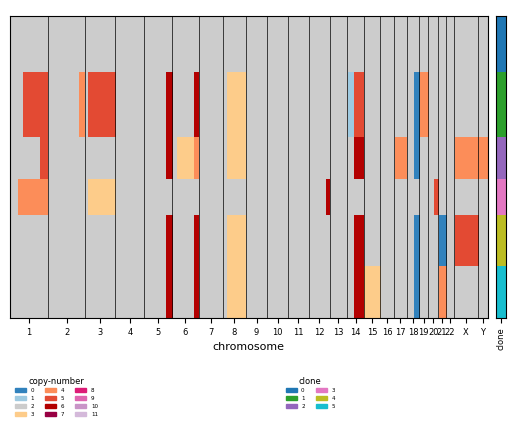

In [124]:
import matplotlib.pyplot as plt
# scgenome comparison
out_ad.layers['copy-number'] = out_ad.layers['victree-cn-viterbi']
out_ad.obs['clone'] = out_ad.obs['victree-clone']
g = pl.plot_cell_cn_matrix_fig(out_ad, layer_name='copy-number', cell_order_fields=['clone'],
                           annotation_fields=['clone'], max_cn=6)
plt.savefig(os.path.join(dataset_path, "cn.png"))

In [125]:
from io import StringIO
from utils.tree_utils import parse_newick, relabel_nodes
import networkx as nx
from networkx.drawing.nx_agraph import pygraphviz_layout
import numpy as np


In [134]:
vi_newick =str(out_ad.uns['victree-tree-newick'][0], 'UTF-8')
print(vi_newick)
print(out_ad.uns['victree-tree-probs'])
vi_tree = parse_newick(StringIO(vi_newick))
vi_tree = nx.relabel_nodes(vi_tree, {str(i): i for i in range(len(vi_tree.nodes()))})
print(vi_tree.nodes())
print(vi_tree.edges())

col_dict = g['annotation_info']['clone']['level_colors']


(3,((1,2)4)5)0
[nan nan nan]
[0, 3, 5, 4, 1, 2]
[(0, 3), (0, 5), (5, 4), (4, 1), (4, 2)]


In [128]:
out_ad.uns['victree-tree-newick']

array([b'(3,((1,2)4)5)0', b'(3,(1,(2)4)5)0', b'(3,((1,2)5)4)0'],
      dtype='|S14')

In [129]:
true_newick =str(in_ad.uns['tree-newick'][0], 'UTF-8')
true_tree_unlab = parse_newick(StringIO(true_newick))
order = [0, 3, 4, 5, 1, 2] # 9979
# order = [0, 3, 5, 4, 1, 2] # 9381
ord_dict = {str(o): i for i, o in enumerate(order)}
true_tree = nx.relabel_nodes(true_tree_unlab, ord_dict)
print(true_tree.nodes())
print(true_tree.edges())

[0, 5, 3, 4, 1, 2]
[(0, 5), (0, 3), (5, 4), (4, 1), (4, 2)]


/tmp/ipykernel_5059/2914992665.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


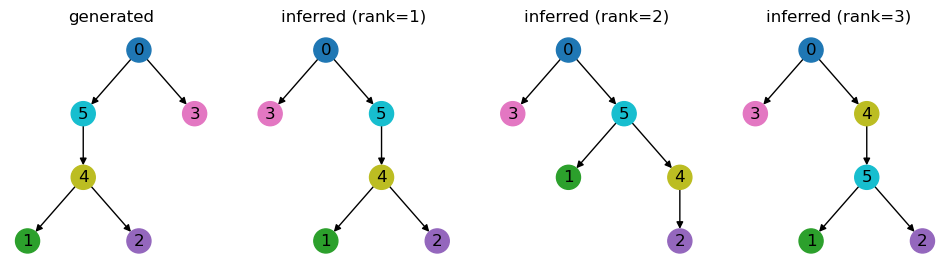

In [136]:
fig, axs = plt.subplots(ncols=4, figsize=(12, 3))

for ai in range(3):
    vi_newick =str(out_ad.uns['victree-tree-newick'][ai], 'UTF-8')
    vi_tree = parse_newick(StringIO(vi_newick))
    vi_tree = nx.relabel_nodes(vi_tree, {str(i): i for i in range(len(vi_tree.nodes()))})
    colors = [col_dict[i] for i in vi_tree.nodes()]
    pos = pygraphviz_layout(vi_tree, prog='dot')
    nx.draw(vi_tree, node_color=colors, with_labels=True, pos=pos, ax=axs[ai+1])

colors = [col_dict[i] for i in true_tree.nodes()]
pos = pygraphviz_layout(true_tree, prog='dot')
nx.draw(true_tree, node_color=colors, with_labels=True, pos=pos, ax=axs[0])

axs[0].set_title("generated")
axs[1].set_title(f"inferred (rank=1)")
axs[2].set_title(f"inferred (rank=2)")
axs[3].set_title(f"inferred (rank=3)")
fig.show()
plt.savefig(os.path.join(dataset_path, "trees.png"))

Text(0.5, 1.0, 'corrected counts and copy number profile (clone 5)')

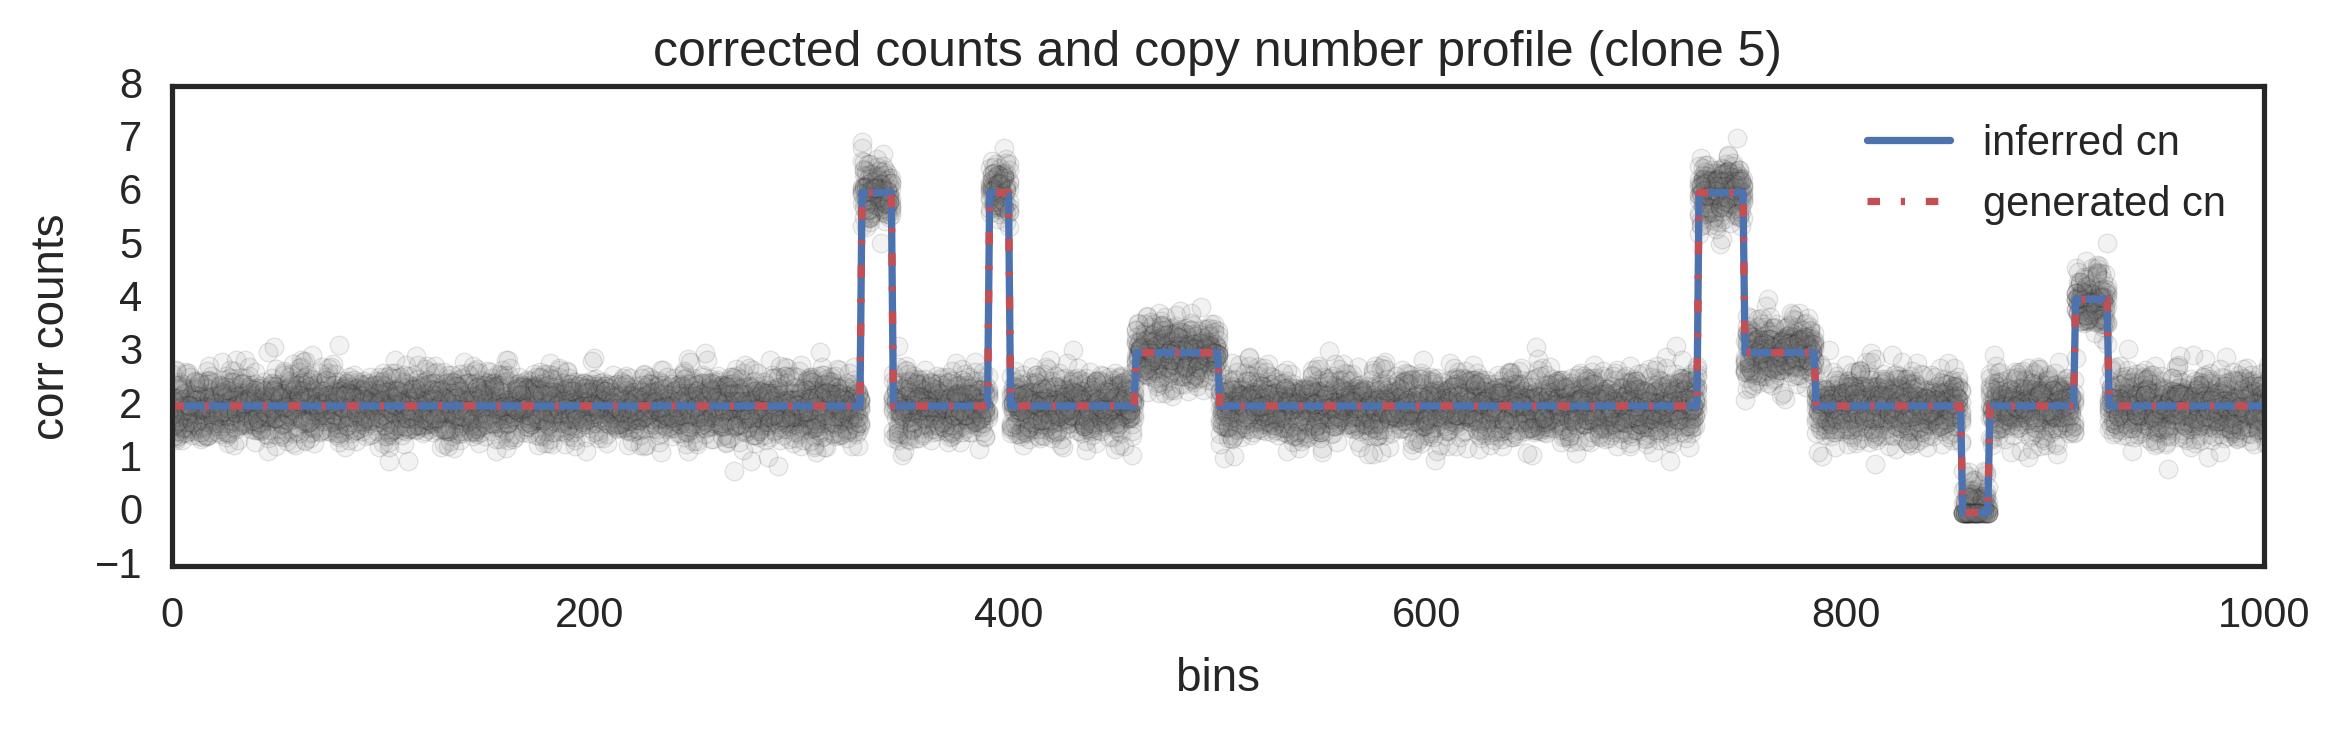

In [175]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn-v0_8-white')
style_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

corr_counts5 = in_ad.layers['copy'][out_ad.obs['victree-clone'] == 5,:]
cn5 = out_ad.layers['victree-cn-viterbi'][out_ad.obs['victree-clone'] == 5, :][0]
cn5_true = in_ad.layers['state'][out_ad.obs['victree-clone'] == 5, :][0]
fig, ax = plt.subplots(figsize=(9, 2), dpi=300)
n_cells = 10
ax.scatter(np.tile(np.arange(corr_counts5.shape[1]), n_cells), corr_counts5[:n_cells,:].flatten(), alpha=.1, c='grey')
ax.plot(np.arange(cn5.size), cn5, c=style_colors[0], label='inferred cn')
ax.plot(np.arange(cn5.size), cn5_true, c=style_colors[2], label='generated cn', linestyle='-.')
ax.set_xlabel('bins')
ax.set_ylabel('corr counts')
ax.set_xlim(0, 1000)
ax.legend()
ax.set_title('corrected counts and copy number profile (clone 5)')